In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

In [2]:
# Read in data and output some info
df = pd.read_csv("../employee_survey.csv")
display(df.shape)
display(df.head())
display(df.info())

(3025, 23)

,EmpID,Gender,Age,MaritalStatus,JobLevel,Experience,Dept,EmpType,WLB,WorkEnv,...,SleepHours,CommuteMode,CommuteDistance,NumCompanies,TeamSize,NumReports,EduLevel,haveOT,TrainingHoursPerYear,JobSatisfaction
0,6,Male,32,Married,Mid,7,IT,Full-Time,1,1,...,7.6,Car,20,3,12,0,Bachelor,True,33.5,5
1,11,Female,34,Married,Mid,12,Finance,Full-Time,1,1,...,7.9,Car,15,4,11,0,Bachelor,False,36.0,5
2,33,Female,23,Single,Intern/Fresher,1,Marketing,Full-Time,2,4,...,6.5,Motorbike,17,0,30,0,Bachelor,True,10.5,5
3,20,Female,29,Married,Junior,6,IT,Contract,2,2,...,7.5,Public Transport,13,2,9,0,Bachelor,True,23.0,5
4,28,Other,23,Single,Junior,1,Sales,Part-Time,3,1,...,4.9,Car,20,0,7,0,Bachelor,False,20.5,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   EmpID                  3025 non-null   int64  
 1   Gender                 3025 non-null   object 
 2   Age                    3025 non-null   int64  
 3   MaritalStatus          3025 non-null   object 
 4   JobLevel               3025 non-null   object 
 5   Experience             3025 non-null   int64  
 6   Dept                   3025 non-null   object 
 7   EmpType                3025 non-null   object 
 8   WLB                    3025 non-null   int64  
 9   WorkEnv                3025 non-null   int64  
 10  PhysicalActivityHours  3025 non-null   float64
 11  Workload               3025 non-null   int64  
 12  Stress                 3025 non-null   int64  
 13  SleepHours             3025 non-null   float64
 14  CommuteMode            3025 non-null   object 
 15  Comm

None

In [3]:
# Output a list of all the categorical features
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    print(f"Unique values in {col}:")
    print(df[col].unique())
    print("\n")

Unique values in Gender:
['Male' 'Female' 'Other']


Unique values in MaritalStatus:
['Married' 'Single' 'Divorced' 'Widowed']


Unique values in JobLevel:
['Mid' 'Intern/Fresher' 'Junior' 'Senior' 'Lead']


Unique values in Dept:
['IT' 'Finance' 'Marketing' 'Sales' 'Operations' 'Customer Service'
 'Legal' 'HR']


Unique values in EmpType:
['Full-Time' 'Contract' 'Part-Time']


Unique values in CommuteMode:
['Car' 'Motorbike' 'Public Transport' 'Bike' 'Walk']


Unique values in EduLevel:
['Bachelor' 'High School' 'Master' 'PhD']




In [4]:
display(df['JobLevel'].value_counts())
display(df['EduLevel'].value_counts())

JobLevel
Senior            1069
Mid                766
Junior             602
Lead               386
Intern/Fresher     202
Name: count, dtype: int64

EduLevel
Bachelor       2300
Master          380
High School     245
PhD             100
Name: count, dtype: int64

## Pre-processing

In [5]:
# Employee ID is not useful
df.drop(columns=['EmpID'], inplace=True) 

In [6]:
ordinal_features = ['EduLevel', 'JobLevel']
nominal_features = ['Gender', 'MaritalStatus', 'Dept', 'EmpType', 'CommuteMode']

# Feature values for Ordinal Encoding
edu_levels = ['High School', 'Bachelor', 'Master', 'PhD']
job_levels = ['Intern/Fresher', 'Junior', 'Mid', 'Senior', 'Lead']

ordinal_mappings = [edu_levels, job_levels]

ordinal_encoder = OrdinalEncoder(categories=ordinal_mappings)
df[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])

# Encode nominal features
df = pd.get_dummies(df, columns=nominal_features, drop_first=True)

# Convert boolean to int
df['haveOT'] = df['haveOT'].astype(int)

# Input variables
X = df.drop(columns=['JobSatisfaction'])

# Target variables
y = df['JobSatisfaction']
y = np.ravel(y)

## Decision Trees

In [7]:
# Hyperparameter map for decision trees
param_grid_dt = {
    'max_depth': range(1, 11),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}
cv_scores = []

# 5-fold CV to get depth resulting in best average accuracy
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X, y)
print(f'Best params: {grid_search_dt.best_params_}')
print(f'Best Accuracy: {grid_search_dt.best_score_}')

Best params: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 8}
Best Accuracy: 0.4416528925619835


/opt/anaconda3/envs/MSE446/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [8]:
# Save the best params
MAX_DEPTH_DT = grid_search_dt.best_params_['max_depth']
MIN_SPLIT_DT = grid_search_dt.best_params_['min_samples_split']
MIN_LEAF_DT = grid_search_dt.best_params_['min_samples_leaf']

In [9]:
best_dt = grid_search_dt.best_estimator_

# Display the decision tree as text
tree_text = export_text(best_dt, feature_names=list(X.columns))
print(tree_text)

|--- WorkEnv <= 2.50
|   |--- Workload <= 3.50
|   |   |--- SleepHours <= 6.35
|   |   |   |--- WLB <= 2.50
|   |   |   |   |--- Experience <= 18.50
|   |   |   |   |   |--- NumReports <= 5.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- NumReports >  5.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Experience >  18.50
|   |   |   |   |   |--- Stress <= 1.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- Stress >  1.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |--- WLB >  2.50
|   |   |   |   |--- EduLevel <= 1.50
|   |   |   |   |   |--- SleepHours <= 5.65
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- SleepHours >  5.65
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |--- EduLevel >  1.50
|   |   |   |   |   |--- TeamSize <= 22.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- TeamSize >  22.50
|   |   |   |   |   |   |--- class: 5
|   |   |--- SleepHours >  6.35
|   |   |   |--- Stress <= 

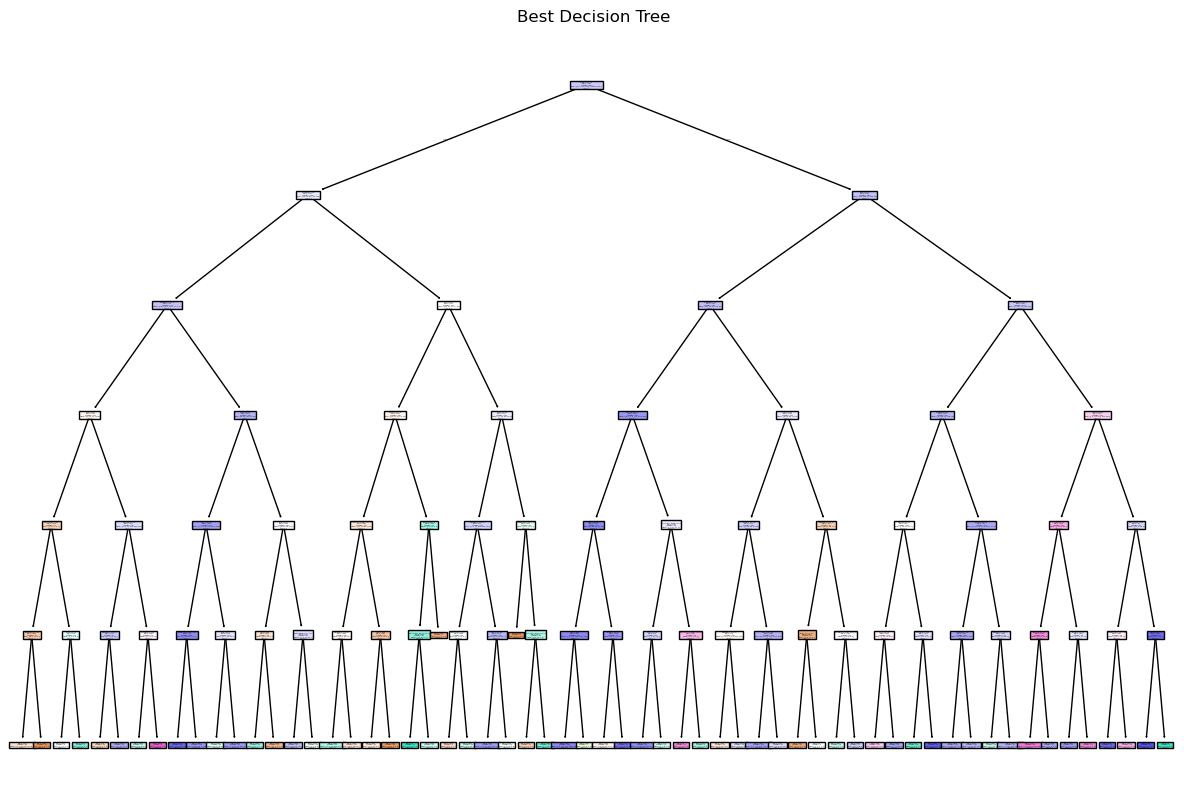

In [10]:
# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(best_dt, filled=True, feature_names=X.columns, class_names=[str(c) for c in set(y)])
plt.title("Best Decision Tree")
plt.savefig('decision_tree_image.png', transparent = True)
plt.show()

## Random Forest

In [11]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': range(1, 15),  # Tree depth
    'min_samples_split': range(2, 11),  # Minimum samples to split a node
    'min_samples_leaf': range(1, 11)  # Minimum samples at a leaf node
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-Fold CV
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X, y)

# Best hyperparameters
best_params_rf = grid_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)
print("Best accuracy: ", grid_search_rf.best_score_)

Fitting 5 folds for each of 5040 candidates, totalling 25200 fits
Best Parameters for Random Forest: {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 50}
Best accuracy:  0.4690909090909091


In [12]:
# Save best hyperparams
N_EST = grid_search_rf.best_params_['n_estimators']
MAX_DEPTH_RF = grid_search_rf.best_params_['max_depth']
MIN_SPLIT_RF = grid_search_rf.best_params_['min_samples_split']
MIN_LEAF_RF = grid_search_rf.best_params_['min_samples_leaf']

## Bagging

In [13]:
# Create RF with the best hyperparams
base_rf = RandomForestClassifier(
    max_depth=MAX_DEPTH_RF,
    min_samples_split=MIN_SPLIT_RF,
    min_samples_leaf=MIN_LEAF_RF,
    n_estimators=N_EST,
    random_state=42
)

# Hyperparam grid for bagging
param_grid_bagging = {
    'n_estimators': [50, 100, 200, 300],  # Number of base learners
    'max_samples': [0.5, 0.7, 1.0],  # Fraction of dataset used for each base learner
    'max_features': [0.5, 0.7, 1.0]  # Fraction of features used for each base learner
}

bagging_model = BaggingClassifier(estimator=base_rf, random_state=42)
grid_search_bagging = GridSearchCV(bagging_model, param_grid_bagging, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_bagging.fit(X, y)
print("Best Parameters for Bagging:", grid_search_bagging.best_params_)
print("Best accuracy (Bagging):", grid_search_bagging.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Bagging: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
Best accuracy (Bagging): 0.45685950413223136


In [14]:
# Create DT with the best hyperparams
base_dt = DecisionTreeClassifier(
    max_depth=MAX_DEPTH_DT,
    min_samples_split=MIN_SPLIT_DT,
    min_samples_leaf=MIN_LEAF_DT,
    random_state=42
)

# Hyper param grid for boosting
param_grid_boosting = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6]
}
boosting_model = AdaBoostClassifier(estimator=base_dt, random_state=42, algorithm='SAMME')
grid_search_boosting = GridSearchCV(boosting_model, param_grid_boosting, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_boosting.fit(X, y)
print("Best Parameters for Boosting:", grid_search_boosting.best_params_)
print("Best accuracy (Boosting):", grid_search_boosting.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Boosting: {'learning_rate': 0.4, 'n_estimators': 400}
Best accuracy (Boosting): 0.488595041322314
